In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

plt.rc('text', usetex=True)
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=17)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df_matches = pd.read_csv('./matches_with_network_params.csv', index_col=0)

In [16]:
df_matches[:3]

,MatchID,OpponentID,Outcome,OwnScore,OpponentScore,Side,CoachID,Huskies_network_params,Opponent_network_params
0,1,Opponent1,win,1,0,home,Coach1,"{'clustering_coeff': 0.09591148659543136, 'sho...","{'clustering_coeff': 0.12727017100674862, 'sho..."
1,2,Opponent2,tie,1,1,away,Coach1,"{'clustering_coeff': 0.13558418994397967, 'sho...","{'clustering_coeff': 0.15137551104001684, 'sho..."
2,3,Opponent3,loss,0,2,away,Coach1,"{'clustering_coeff': 0.12456657946374812, 'sho...","{'clustering_coeff': 0.1305149813894459, 'shor..."


### Flexibility
每场每个队算一个mean 50time, 然后看看二哈和别的队的mean 50time有没有相关性？

In [17]:
def parse_time(team, matchid):
    df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
    df = df[df['MatchID'] == matchid]
    df = df[df['TeamID'] == team]
    
    df_full = pd.read_csv('./2020_Problem_D_DATA/fullevents.csv')
    df_full = df_full[df_full['MatchID'] == matchid]
    df_full = df_full[df_full['TeamID'] == team]
    first_half_time = df_full[df_full['MatchPeriod'] == '1H'].iloc[-1]['EventTime']
    
    df.loc[df['MatchPeriod'] == '2H', 'EventTime'] += first_half_time
    return df

In [18]:
def temporal_50time(team, matchid, length=50):
    from network import build_network, plot_network, calc_network_params
    df = parse_time(team, matchid)
    
    df = df[df['TeamID'] == team]
    df = df[df['MatchID'] == matchid]
    time = df['EventTime'].values
    
    net_param_dict = {}
    for i in range(len(df)):
        if length + i >= len(df):
            break
        network_params = {}
        local_time = time[length + i] - time[i]
        network_params['delta_time'] = local_time
        network_params['time'] = time[length + i]
        net_param_dict[i] = network_params
        
    df_net_param = pd.DataFrame(net_param_dict).T
    return df_net_param

In [19]:
plt.rc('text', usetex=False)

In [20]:
for ind, row in df_matches.iterrows():
    df_net_huskies = temporal_50time('Huskies', row['MatchID'])
    df_net_opponent = temporal_50time(row['OpponentID'], row['MatchID'])

    df_matches.loc[ind, 'Huskies_mean_50time'] = np.mean(df_net_huskies['delta_time'].values)
    df_matches.loc[ind, 'Opponent_mean_50time'] = np.mean(df_net_opponent['delta_time'].values)

In [21]:
# nice discovery!
df_matches.groupby('Outcome').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time
Outcome,,,,,
loss,18.000000,0.533333,2.866667,1124.603373,829.814018
tie,20.500000,0.800000,0.800000,1408.151505,881.789048
win,20.461538,2.153846,0.538462,915.244773,1078.006041


### Time-lag cross correlation between t_{50}

In [22]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [23]:
for ind, row in df_matches.iterrows():
    df_net_huskies = temporal_50time('Huskies', row['MatchID'])
    df_net_opponent = temporal_50time(row['OpponentID'], row['MatchID'])

    from scipy.interpolate import interp1d
    f_h = interp1d(df_net_huskies['time'].values / 60, 
                   df_net_huskies['delta_time'].values / 60, 
                   kind='linear')
    f_o = interp1d(df_net_opponent['time'].values / 60, 
                   df_net_opponent['delta_time'].values / 60, 
                   kind='linear')

    x_min = max(np.min(df_net_opponent['time'].values / 60), 
                np.min(df_net_huskies['time'].values / 60))
    x_max = min(np.max(df_net_opponent['time'].values / 60), 
                np.max(df_net_huskies['time'].values / 60))
    x_input = np.linspace(x_min, x_max, 100)
    d1 = pd.Series(f_h(x_input))
    d2 = pd.Series(f_o(x_input))

    rs = [crosscorr(d1, d2, lag) for lag in range(-50, 51)]
    time_lag = (x_input[1] - x_input[0]) * range(-50, 51)[np.argmax(rs)]
    df_matches.loc[ind, 'time_lag'] = (time_lag)
    

In [24]:
# nice discovery!
df_matches.groupby('Outcome').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Outcome,,,,,,
loss,18.000000,0.533333,2.866667,1124.603373,829.814018,-6.687771
tie,20.500000,0.800000,0.800000,1408.151505,881.789048,-0.028306
win,20.461538,2.153846,0.538462,915.244773,1078.006041,-2.180500


In [25]:
# nice discovery!
df_matches.groupby('Outcome').median()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Outcome,,,,,,
loss,21.0,0.0,3.0,1022.249260,731.820699,-15.736479
tie,19.5,1.0,1.0,1061.081887,810.766224,7.082033
win,18.0,2.0,0.0,872.847593,1033.427790,-1.554976


In [26]:
df_matches.to_csv('./matches_flexibility.csv')

#### Flexibility example

MatchID=18
MatchID=26


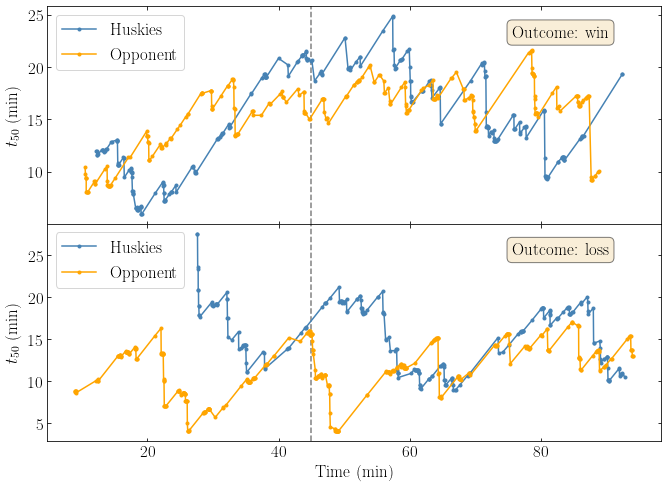

In [77]:
# Flexible example
plt.rc('text', usetex=True)
fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

indices = [17, 25]
for i in range(2):
    ax = axes[i]
    
    row = df_matches.loc[indices[i]]
    print('MatchID={}'.format(row['MatchID']))
    df_net_huskies = temporal_50time('Huskies', row['MatchID'])
    df_net_opponent = temporal_50time(row['OpponentID'], row['MatchID'])


    ax.plot(df_net_huskies['time'].values / 60, df_net_huskies['delta_time'].values / 60, 
            color='steelblue', marker='.', label='Huskies')
    ax.plot(df_net_opponent['time'].values / 60, df_net_opponent['delta_time'].values / 60, 
            color='orange', marker='.', label='Opponent')

    ax.set_ylabel(r'$t_{50}$ (min)')
    ax.set_xlabel('Time (min)')

    ax.tick_params(direction='in', left=True, right=True, 
                    bottom=True, top=True, labelleft=True, labelbottom=False)

    ax.legend(loc='upper left')

    ylim = ax.get_ylim()
    ax.vlines(45, ylim[0], ylim[1], linestyle='--', colors='gray')
    ax.text(83, ylim[0] + 0.88 * (ylim[1] - ylim[0]), 
            'Outcome: {}'.format(row['Outcome']), 
            fontsize=17,
            horizontalalignment='center', 
            verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.set_ylim(ylim)

axes[1].tick_params(direction='in', left=True, right=True, 
                    bottom=True, top=True, labelleft=True, labelbottom=True)
plt.subplots_adjust(hspace=0)

plt.savefig('./Draft/flexible_example.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/flexible_example.png', dpi=200, bbox_inches='tight')
#plt.close()

#### Not-so-flexible example
???

## 赛区比赛结果

In [364]:
def color_func(p):
    if p > 0.2:
        return 'dodgerblue'
    elif p < 0.05:
        return 'orange'
    else:
        return 'seagreen'

In [289]:
ranking = {
    'Opponent14': 13,
    'Opponent13': 17,
    'Opponent15': 16,
    'Opponent17': 12,
    'Opponent18': 18,
    'Opponent16': 4,
    'Opponent2': 1,
    'Opponent1': 19,
    'Opponent8': 14,
    'Opponent7': 7,
    'Opponent11': 15,
    'Opponent12': 11,
    'Opponent9': 6,
    'Opponent10': 9,
    'Opponent19': 20,
    'Opponent4': 3,
    'Opponent5': 2,
    'Opponent6': 10,
    'Opponent3': 5
}

In [341]:
ranking = pd.Series(ranking)
ranking = ranking.sort_values()

In [360]:
ind = np.in1d(df_matches['OpponentID'], ranking[ranking <= 5].index.values)
df_win = df_matches.iloc[ind]

column = df_win['Huskies_network_params']
huskies_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

column = df_win['Opponent_network_params']
oppo_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

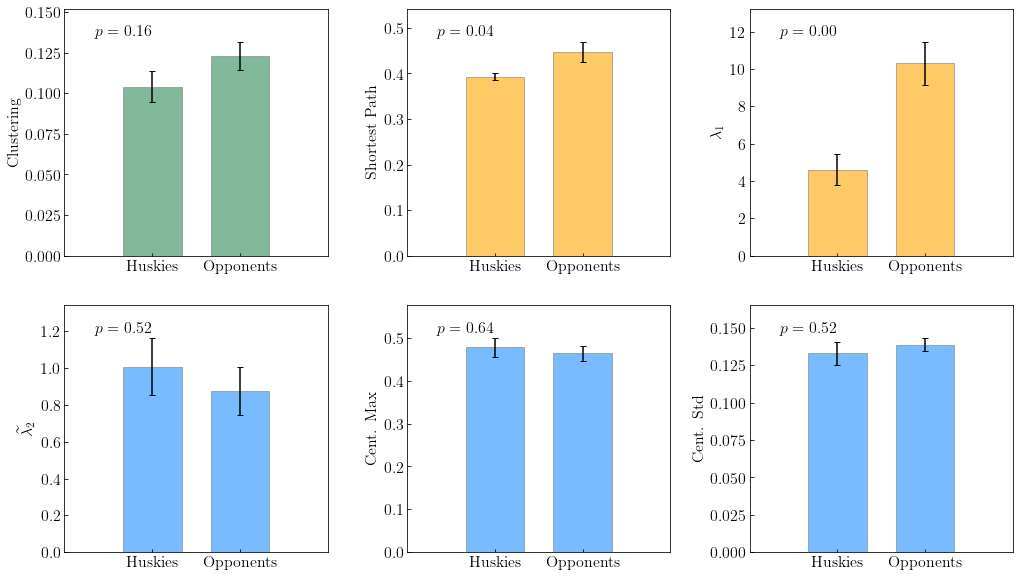

In [365]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

ylabel_set = ['Clustering', 'Shortest Path', 
              r'$\lambda_1$', r'$\widetilde{\lambda_2}$', 
              'Cent. Max', 'Cent. Std']

for ind, column in enumerate(huskies_params.columns):
    ax = axes[ind // 3, ind % 3]
    
    huskie = calc_mean_std(huskies_params[column]) 
    oppo = calc_mean_std(oppo_params[column])
    
    levene = stats.levene(huskies_params[column].values, oppo_params[column].values)
    ttest = stats.ttest_ind(huskies_params[column].values, 
                            oppo_params[column].values, 
                            equal_var=(levene.pvalue > 0.10))
    pvalue = ttest.pvalue

    x_label = ['Huskies', 'Opponents']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [huskie[0], oppo[0]], 
           yerr=[huskie[1], oppo[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.2f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
plt.subplots_adjust(wspace=0.3)

plt.savefig('./Draft/top6-network-params.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/top6-network-params.png', dpi=200, bbox_inches='tight')

In [373]:
ind = np.in1d(df_matches['OpponentID'], ranking[ranking >= 15].index.values)
df_win = df_matches.iloc[ind]

column = df_win['Huskies_network_params']
huskies_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

column = df_win['Opponent_network_params']
oppo_params = pd.DataFrame.from_dict({
    np.array(column.index)[ind]: eval(item)
    for ind, item in enumerate(column.values)
    }, orient='index')

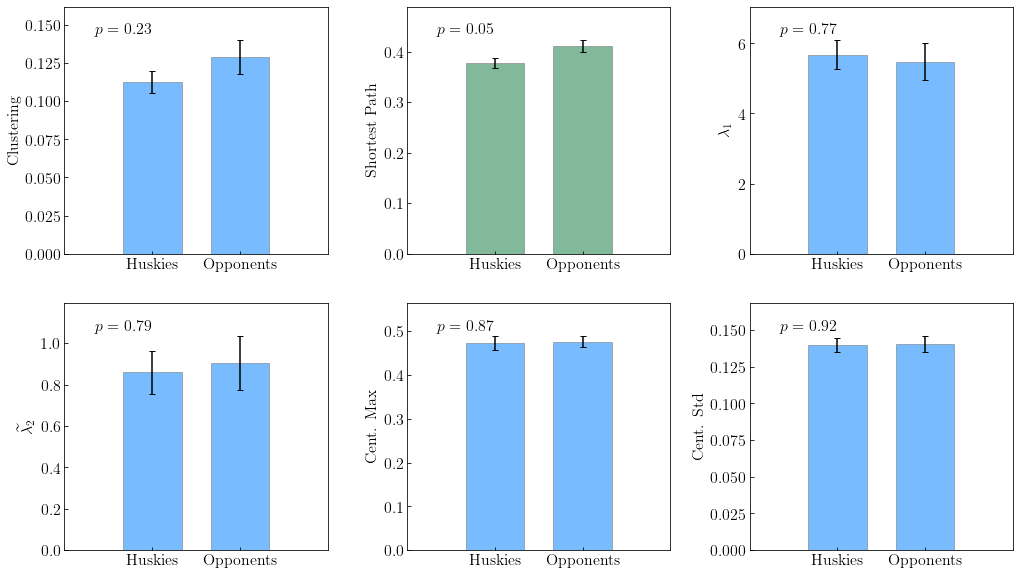

In [375]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

ylabel_set = ['Clustering', 'Shortest Path', 
              r'$\lambda_1$', r'$\widetilde{\lambda_2}$', 
              'Cent. Max', 'Cent. Std']

for ind, column in enumerate(huskies_params.columns):
    ax = axes[ind // 3, ind % 3]
    
    huskie = calc_mean_std(huskies_params[column]) 
    oppo = calc_mean_std(oppo_params[column])
    
    levene = stats.levene(huskies_params[column].values, oppo_params[column].values)
    ttest = stats.ttest_ind(huskies_params[column].values, 
                            oppo_params[column].values, 
                            equal_var=(levene.pvalue > 0.10))
    pvalue = ttest.pvalue

    x_label = ['Huskies', 'Opponents']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [huskie[0], oppo[0]], 
           yerr=[huskie[1], oppo[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.2f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
plt.subplots_adjust(wspace=0.3)

plt.savefig('./Draft/bottom6-network-params.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/bottom6-network-params.png', dpi=200, bbox_inches='tight')